# Avaliação - Regressão usando MLP
## Inferir custos médicos do plano de saúde a partir do arquivo insurance.csv

### Carregamento dos dados

In [1181]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [1182]:
insurance = pd.read_csv(Path('insurance.csv'))
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [1183]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Preparação dos dados

In [1184]:
#função para reverter o pandas.get_dummies()
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [1185]:
one_hot_encoding = pd.get_dummies(insurance[['sex', 'region', 'smoker']])
one_hot_encoding.head()

,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes
0,1,0,0,0,0,1,0,1
1,0,1,0,0,1,0,1,0
2,0,1,0,0,1,0,1,0
3,0,1,0,1,0,0,1,0
4,0,1,0,1,0,0,1,0


In [1186]:
insurance = insurance.drop(['sex', 'region', 'smoker'], axis = 1)

In [1187]:
insurance = pd.concat([insurance, one_hot_encoding], axis=1)
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   charges           1338 non-null   float64
 4   sex_female        1338 non-null   uint8  
 5   sex_male          1338 non-null   uint8  
 6   region_northeast  1338 non-null   uint8  
 7   region_northwest  1338 non-null   uint8  
 8   region_southeast  1338 non-null   uint8  
 9   region_southwest  1338 non-null   uint8  
 10  smoker_no         1338 non-null   uint8  
 11  smoker_yes        1338 non-null   uint8  
dtypes: float64(2), int64(2), uint8(8)
memory usage: 52.4 KB


In [1188]:
insurance.corr()['charges'].sort_values()

smoker_no          -0.787251
sex_female         -0.057292
region_southwest   -0.043210
region_northwest   -0.039905
region_northeast    0.006349
sex_male            0.057292
children            0.067998
region_southeast    0.073982
bmi                 0.198341
age                 0.299008
smoker_yes          0.787251
charges             1.000000
Name: charges, dtype: float64

In [1189]:
train_set, test_set = train_test_split(insurance, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

1070 train + 268 test


In [1190]:
y_train, y_test = train_set['charges'], test_set['charges']

In [1191]:
x_train, x_test = train_set.drop(['charges'], axis=1), test_set.drop(['charges'], axis=1)
x_train.head()

,age,bmi,children,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes
560,46,19.95,2,1,0,0,1,0,0,1,0
1285,47,24.32,0,1,0,1,0,0,0,1,0
1142,52,24.86,0,1,0,0,0,1,0,1,0
969,39,34.32,5,1,0,0,0,1,0,1,0
486,54,21.47,3,1,0,0,1,0,0,1,0


### Treinamento e avaliação

### Random Forest

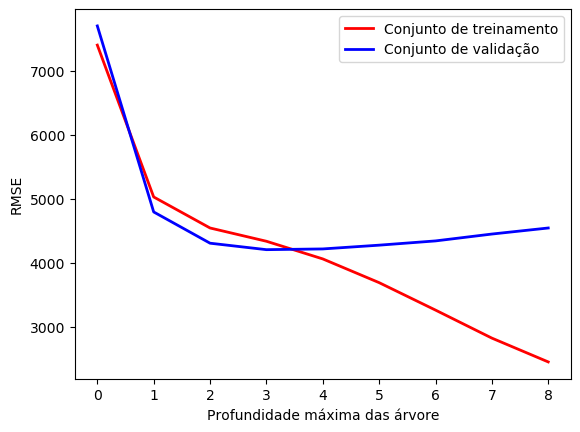

In [1192]:
from sklearn.ensemble import RandomForestRegressor

def plot_learning_curves_random_forest(X, y, max_depth):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for max in range(1, max_depth):
        model = RandomForestRegressor(n_estimators=500, random_state=42, max_depth=max, n_jobs=-1)
        model.fit(X_train, y_train)
        y_train_predict = model.predict(X_train)
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.xlabel("Profundidade máxima das árvore")
    plt.ylabel("RMSE")
    plt.plot(np.sqrt(train_errors), "r-", linewidth=2, label="Conjunto de treinamento")  
    plt.plot(np.sqrt(val_errors), "b-", linewidth=2, label="Conjunto de validação")
    plt.legend()

plot_learning_curves_random_forest(pd.concat([x_train, x_test]), pd.concat([y_train, y_test]), 10)

In [1193]:
regressor = RandomForestRegressor(n_estimators=500, max_depth=4, random_state=42, n_jobs=-1)
regressor.fit(x_train, y_train)
resultado_random_forest_train = regressor.predict(x_train)
resultado_random_forest_test = regressor.predict(x_test)

In [1194]:
#K-fold cross validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
resultados_mse_train = []
resultados_mae_train = []
resultados_r2_train = []
resultados_mse_test = []
resultados_mae_test = []
resultados_r2_test = []
x_full = pd.concat([x_train, x_test])
y_full = pd.concat([y_train, y_test])

for train_index, test_index in kf.split(x_full):
    x_train_fold, x_test_fold = x_full.iloc[train_index], x_full.iloc[test_index]
    y_train_fold, y_test_fold = y_full.iloc[train_index], y_full.iloc[test_index]

    
    regressor.fit(x_train_fold, y_train_fold)
    resultado_random_forest_train_k = regressor.predict(x_train_fold)
    resultado_random_forest_test_k = regressor.predict(x_test_fold)
    resultados_mse_train.append(mean_squared_error(y_train_fold, resultado_random_forest_train_k))
    resultados_mae_train.append(mean_absolute_error(y_train_fold, resultado_random_forest_train_k))
    resultados_r2_train.append(r2_score(y_train_fold, resultado_random_forest_train_k))
    resultados_mse_test.append(mean_squared_error(y_test_fold, resultado_random_forest_test_k))
    resultados_mae_test.append(mean_absolute_error(y_test_fold, resultado_random_forest_test_k))
    resultados_r2_test.append(r2_score(y_test_fold, resultado_random_forest_test_k))
    

In [1195]:
from statistics import mean

print('MSE, MAE E R2 NO TREINO - RANDOM FOREST')
print(mean_squared_error(y_train, resultado_random_forest_train))
print(mean_absolute_error(y_train, resultado_random_forest_train))
print(r2_score(y_train, resultado_random_forest_train))

print('MSE, MAE E R2 NO TESTE - RANDOM FOREST')
print(mean_squared_error(y_test, resultado_random_forest_test))
print(mean_absolute_error(y_test, resultado_random_forest_test))
print(r2_score(y_test, resultado_random_forest_test))

print('MSE, MAE E R2 COM K_FOLD_CROSS_VALIDATION NO TREINO - RANDOM FOREST')
print(mean(resultados_mse_train))
print(mean(resultados_mae_train))
print(mean(resultados_r2_train))

print('MSE, MAE E R2 COM K_FOLD_CROSS_VALIDATION NO TESTE - RANDOM FOREST')
print(mean(resultados_mse_test))
print(mean(resultados_mae_test))
print(mean(resultados_r2_test))

MSE, MAE E R2 NO TREINO - RANDOM FOREST
18366012.763834246
2438.5164017497555
0.8727530528379521
MSE, MAE E R2 NO TESTE - RANDOM FOREST
19866312.203405954
2581.6905132361494
0.8720355908063657
MSE, MAE E R2 COM K_FOLD_CROSS_VALIDATION NO TREINO - RANDOM FOREST
17502878.7470285
2339.7790967331034
0.8802227268107234
MSE, MAE E R2 COM K_FOLD_CROSS_VALIDATION NO TESTE - RANDOM FOREST
21187071.683167905
2585.5129761043067
0.8541610110732579


### Rede Neural com TensorFlow e Keras

In [1196]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
keras.layers.Dense(12, activation="elu", kernel_initializer=keras.initializers.HeNormal(seed=42), input_shape=[11]),
keras.layers.BatchNormalization(),
keras.layers.Dropout(rate=0.10),
keras.layers.Dense(12, activation="elu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dropout(rate=0.10),
keras.layers.Dense(12, activation="elu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dropout(rate=0.10),
keras.layers.Dense(12, activation="elu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dropout(rate=0.10),
keras.layers.Dense(12, activation="elu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dropout(rate=0.10),
keras.layers.Dense(12, activation="elu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dropout(rate=0.10),
keras.layers.Dense(12, activation="elu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dropout(rate=0.10),
keras.layers.Dense(12, activation="elu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dropout(rate=0.10),
keras.layers.Dense(12, activation="elu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dropout(rate=0.10),
keras.layers.Dense(12, activation="elu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dropout(rate=0.10),
keras.layers.Dense(12, activation="elu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.BatchNormalization(),
keras.layers.Dropout(rate=0.10),
keras.layers.Dense(12, activation="elu", kernel_initializer=keras.initializers.HeNormal(seed=42)),
keras.layers.Dropout(rate=0.10),
keras.layers.Dense(1)
])

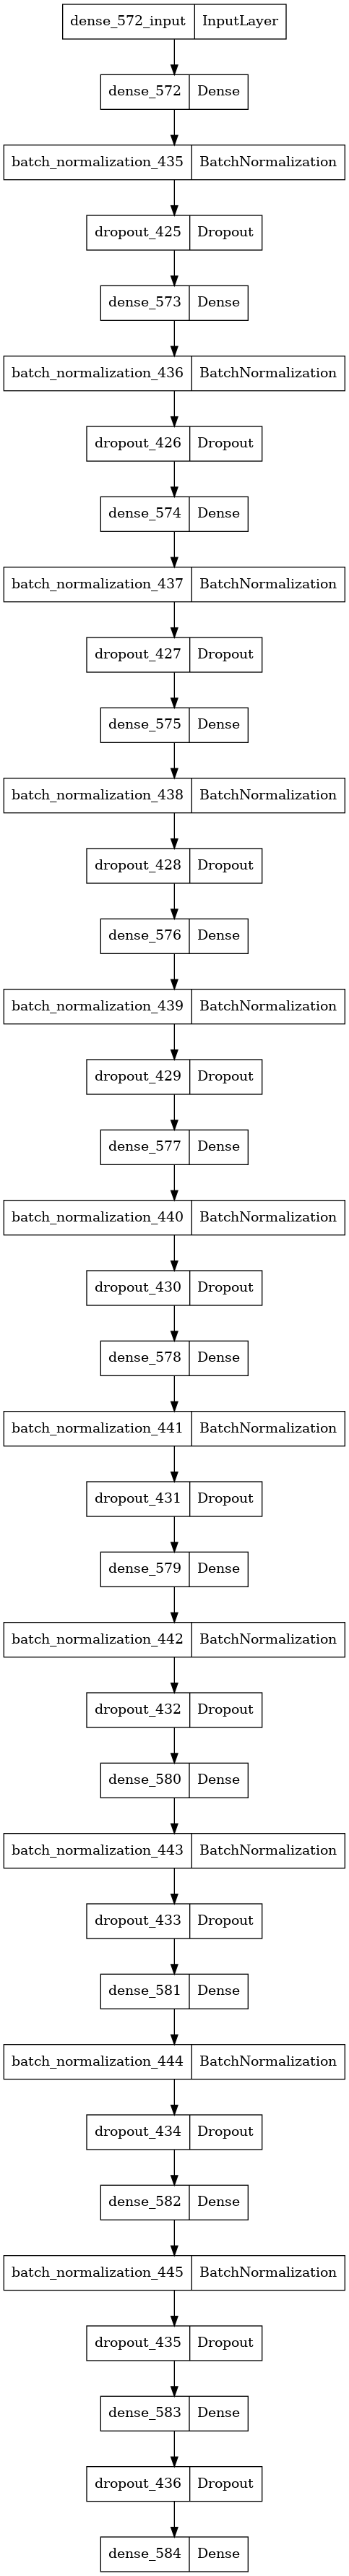

In [1197]:
keras.utils.plot_model(model, to_file = "model.png")

In [1198]:
#Depois de construir o modelo preciso compilar
#Na fase de compilação, define-se, por exemplo
#a função de perda, o otimizador, as métricas para serem calculadas  durante o treinamento e validação e etc

model.compile(loss="mae",
optimizer="adam")

In [1199]:
#learning scheduler
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

def power_decay(lr0, s, c=1):
    def power_decay_fn(epoch):
        return lr0 / (1 + (epoch/s))**c
    return power_decay_fn

exponential_decay = exponential_decay(0.1, 20)
power_decay = power_decay(0.1, 20)
learning_rate_scheduler = keras.callbacks.LearningRateScheduler(power_decay, verbose=1)

In [1200]:
#K-fold cross validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
resultados_mse_train = []
resultados_mae_train = []
resultados_r2_train = []
resultados_mse_test = []
resultados_mae_test = []
resultados_r2_test = []
resultados_history = []
x_full = pd.concat([x_train, x_test])
y_full = pd.concat([y_train, y_test])

for train_index, test_index in kf.split(x_full):
    x_train_fold, x_test_fold = x_full.iloc[train_index], x_full.iloc[test_index]
    y_train_fold, y_test_fold = y_full.iloc[train_index], y_full.iloc[test_index]

    resultados_history.append(model.fit(x_train_fold, y_train_fold, epochs=500, validation_data=(x_test_fold, y_test_fold),
    callbacks=[keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]))
    resultado_mlp_train = model.predict(x_train_fold)
    resultado_mlp_test = model.predict(x_test_fold)
    resultados_mse_train.append(mean_squared_error(y_train_fold, resultado_mlp_train))
    resultados_mae_train.append(mean_absolute_error(y_train_fold, resultado_mlp_train))
    resultados_r2_train.append(r2_score(y_train_fold, resultado_mlp_train))
    resultados_mse_test.append(mean_squared_error(y_test_fold, resultado_mlp_test))
    resultados_mae_test.append(mean_absolute_error(y_test_fold, resultado_mlp_test))
    resultados_r2_test.append(r2_score(y_test_fold, resultado_mlp_test))
    

Epoch 1/500
28/28 [==============================] - 4s 20ms/step - loss: 12936.2129 - val_loss: 13930.4141
Epoch 2/500
28/28 [==============================] - 0s 6ms/step - loss: 12935.5664 - val_loss: 13931.6523
Epoch 3/500
28/28 [==============================] - 0s 6ms/step - loss: 12934.8838 - val_loss: 13933.6641
Epoch 4/500
28/28 [==============================] - 0s 6ms/step - loss: 12934.1104 - val_loss: 13933.1963
Epoch 5/500
28/28 [==============================] - 0s 7ms/step - loss: 12932.8955 - val_loss: 13929.1074
Epoch 6/500
28/28 [==============================] - 0s 7ms/step - loss: 12931.3711 - val_loss: 13922.9043
Epoch 7/500
28/28 [==============================] - 0s 6ms/step - loss: 12928.6504 - val_loss: 13917.7305
Epoch 8/500
28/28 [==============================] - 0s 7ms/step - loss: 12925.6309 - val_loss: 13910.2754
Epoch 9/500
28/28 [==============================] - 0s 6ms/step - loss: 12921.9873 - val_loss: 13904.6699
Epoch 10/500
28/28 [================

In [1201]:
history = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test),
callbacks=[keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)])
#callbacks=[keras.callbacks.EarlyStopping(patience=25), learning_rate_scheduler])

Epoch 1/500
34/34 [==============================] - 0s 9ms/step - loss: 4484.8125 - val_loss: 2273.0559
Epoch 2/500
34/34 [==============================] - 0s 6ms/step - loss: 4580.8022 - val_loss: 2143.7803
Epoch 3/500
34/34 [==============================] - 0s 6ms/step - loss: 4422.2568 - val_loss: 2455.2932
Epoch 4/500
34/34 [==============================] - 0s 6ms/step - loss: 4478.6914 - val_loss: 2255.8494
Epoch 5/500
34/34 [==============================] - 0s 6ms/step - loss: 4585.2056 - val_loss: 2886.7939
Epoch 6/500
34/34 [==============================] - 0s 6ms/step - loss: 4492.5698 - val_loss: 2234.3296
Epoch 7/500
34/34 [==============================] - 0s 6ms/step - loss: 4558.4126 - val_loss: 2211.2009
Epoch 8/500
34/34 [==============================] - 0s 6ms/step - loss: 4323.9473 - val_loss: 2293.8257
Epoch 9/500
34/34 [==============================] - 0s 6ms/step - loss: 4498.6963 - val_loss: 2305.3928
Epoch 10/500
34/34 [==============================] - 0

In [1202]:
from statistics import mean
resultado_mlp = model.predict(x_train)
resultado_mlp2 = model.predict(x_test)

print('MSE, MAE E R2 NO TREINO - MLP')
print(mean_squared_error(y_train, resultado_mlp))
print(mean_absolute_error(y_train, resultado_mlp))
print(r2_score(y_train, resultado_mlp))

print('MSE, MAE E R2 NO TESTE - MLP')
print(mean_squared_error(y_test, resultado_mlp2))
print(mean_absolute_error(y_test, resultado_mlp2))
print(r2_score(y_test, resultado_mlp2))

print('MSE, MAE E R2 COM MLP COM K_FOLD_CROSS_VALIDATION NO TREINO - MLP')
print(mean(resultados_mse_train))
print(mean(resultados_mae_train))
print(mean(resultados_r2_train))

print('MSE, MAE E R2 COM MLP COM K_FOLD_CROSS_VALIDATION NO TESTE - MLP')
print(mean(resultados_mse_test))
print(mean(resultados_mae_test))
print(mean(resultados_r2_test))

9/9 [==============================] - 0s 3ms/step
MSE, MAE E R2 NO TREINO - MLP
25612039.84762316
2327.220925722145
0.8225497323174908
MSE, MAE E R2 NO TESTE - MLP
22406516.806589134
2143.7803006164586
0.8556734306857996
MSE, MAE E R2 COM MLP COM K_FOLD_CROSS_VALIDATION NO TREINO - MLP
25182774.457848523
2335.1297224926575
0.8276439827109002
MSE, MAE E R2 COM MLP COM K_FOLD_CROSS_VALIDATION NO TESTE - MLP
25273230.85562828
2355.2120412406366
0.8257279784995845


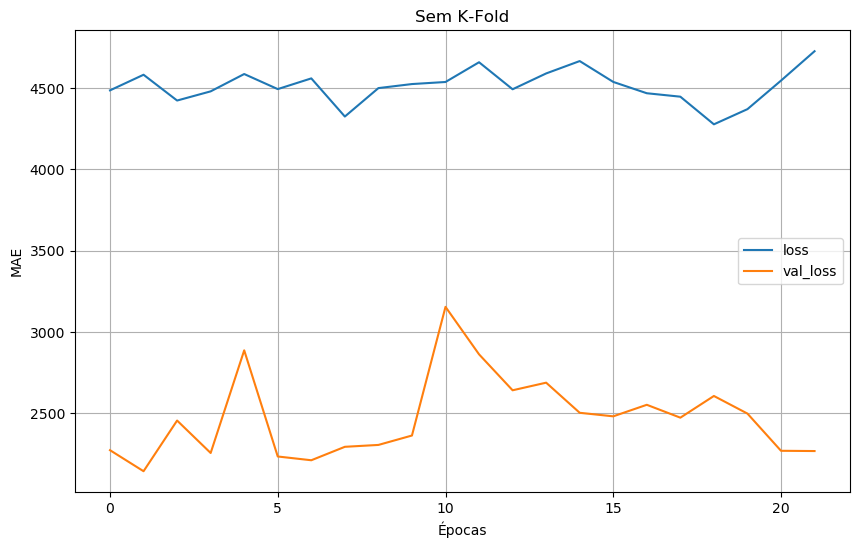

In [1203]:
#Posso fazer curvas de aprendizado com o histórico do treinamento da rede neural
#history.history.pop('lr')
pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.grid(True)
plt.title("Sem K-Fold")
plt.xlabel("Épocas")
plt.ylabel("MAE")
plt.gca()
plt.show()

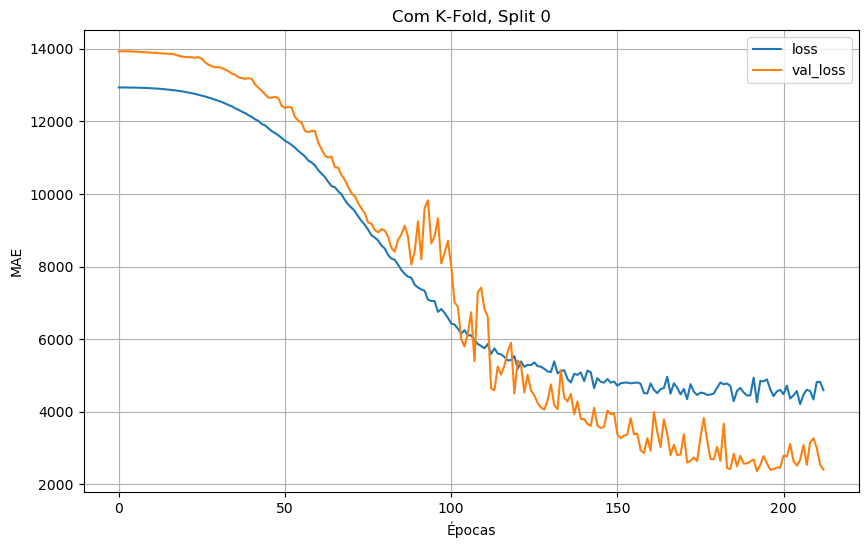

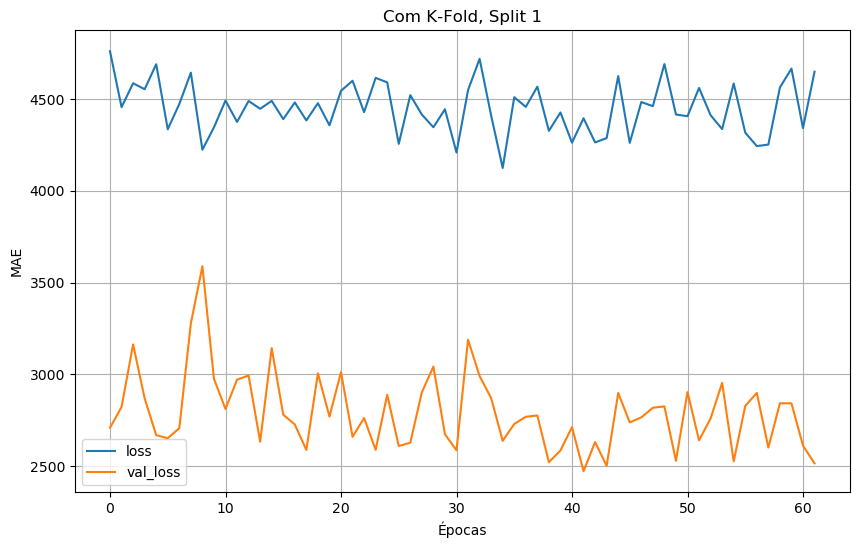

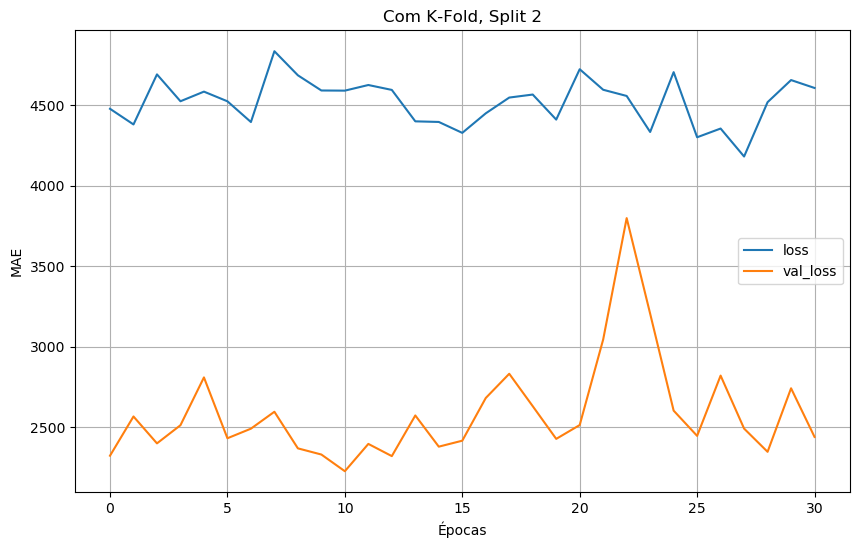

In [1204]:
#define number of rows and columns for subplots
nrow=3
ncol=1

# make a list of all dataframes 
df_list = [pd.DataFrame(resultados_history[0].history),
pd.DataFrame(resultados_history[1].history), pd.DataFrame(resultados_history[2].history)]
fig, axes = plt.subplots(nrow, ncol, sharey=True)
plt.close()
# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot(figsize=(10, 6))
        plt.grid(True)
        plt.title(f"Com K-Fold, Split {count}")
        plt.xlabel("Épocas")
        plt.ylabel("MAE")
        plt.gca()
        plt.show()
        count+=1

In [1205]:
# def build_model(n_hidden=12, n_neurons=12, learning_rate=3e-3, input_shape=[11], optimizer = "nadam"):
#     model = keras.models.Sequential()
#     options = {"input_shape": input_shape}
#     for layer in range(n_hidden):
#         model.add(keras.layers.Dense(n_neurons, activation="elu", **options))
#         options = {}
#     model.add(keras.layers.Dense(1, **options))
#     model.compile(loss="mse", optimizer=optimizer)
#     return model


In [1206]:
# from scikeras.wrappers import KerasRegressor

# #keras_reg = KerasRegressor(build_model, n_hidden=12, n_neurons=12, learning_rate=3e-3, input_shape=[11])
# keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
# #history = keras_reg.fit(x_train, y_train, epochs=300, validation_data=(x_test, y_test))

In [1207]:
# from scipy.stats import reciprocal
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# param_distribs = {
# "n_hidden": np.arange(1, 15),
# "n_neurons": np.arange(1, 15),
# "optimizer": [keras.optimizers.SGD(momentum=0.9, nesterov=True), "Adagrad", "RMSprop", "Adam", "Nadam", "Adamax"],
# #"learning_rate": reciprocal(3e-4, 3e-2),
# #"learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
# #"learning_rate": [0.001, 0.01, 0.1],
# }
# rnd_search_cv = GridSearchCV(keras_reg, param_distribs, cv=3, n_jobs=-1, scoring="r2")
# rnd_search_cv.fit(x_train, y_train, epochs=500,
# validation_data=(x_test, y_test),
# callbacks=[keras.callbacks.EarlyStopping(patience=20, verbose=1, restore_best_weights=True)], verbose=0)

In [1208]:
# rnd_search_cv.best_params_

In [1209]:
# rnd_search_cv.best_score_

In [1210]:
# model = rnd_search_cv.best_estimator_.model

In [1211]:
# resultado_mlp = model.predict(x_train)
# resultado_mlp2 = model.predict(x_test)

# print('MSE, MAE E R2 NO TREINO - MLP GRID SEARCH')
# print(mean_squared_error(y_train, resultado_mlp))
# print(mean_absolute_error(y_train, resultado_mlp))
# print(r2_score(y_train, resultado_mlp))

# resultado_mlp = model.predict(x_test)

# print('MSE, MAE E R2 NO TESTE - MLP GRID SEARCH')
# print(mean_squared_error(y_test, resultado_mlp2))
# print(mean_absolute_error(y_test, resultado_mlp2))
# print(r2_score(y_test, resultado_mlp2))